In [1]:
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ELU, ReLU, Reshape, Input, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout, LSTM, BatchNormalization, ZeroPadding1D, LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Activation, Add, MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalMaxPooling1D, GlobalMaxPooling2D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns

In [2]:
# MinMax 정규화

def standardize_data(df, col, min_value, max_value):
  scaler = MinMaxScaler()
    
  # 표준화할 데이터 준비 (예시로 특정 열만 사용)
  df.reset_index(drop=True, inplace=True)
  data_to_standardize = df.loc[:,[col]]

  # min_value와 max_value를 Series로 변환
  min_series = pd.Series([min_value], index=[len(data_to_standardize)])
  max_series = pd.Series([max_value], index=[len(data_to_standardize) + 1])

  # 최대값, 최솟값 삽입 (Series를 DataFrame에 추가)
  data_to_standardize.loc[len(data_to_standardize)] = min_value
  data_to_standardize.loc[len(data_to_standardize)] = max_value

  # 데이터를 표준화
  standardized_data = scaler.fit_transform(data_to_standardize)

  # 표준화된 데이터를 DataFrame으로 변환
  standardized_df = pd.DataFrame(standardized_data, columns=[col])

  # 원래 데이터에 표준화된 데이터로 업데이트
  df.loc[:, [col]] = standardized_df[[col]].astype(float)

  return df[[col]]

In [3]:
# standard 정규화

def sstandardize_data(df, col):
  scaler = StandardScaler()
    
  # 표준화할 데이터 준비 (예시로 특정 열만 사용)
  df.reset_index(drop=True, inplace=True)
  data_to_standardize = df.loc[:,[col]]
    
  # 데이터를 표준화
  standardized_data = scaler.fit_transform(data_to_standardize)

  # 표준화된 데이터를 DataFrame으로 변환
  standardized_df = pd.DataFrame(standardized_data, columns=[col])

  # 원래 데이터에 표준화된 데이터로 업데이트
  df.loc[:, [col]] = standardized_df[[col]]

  return df[[col]]

In [4]:
# Acc_X, Acc_Y, Gyr_Z 추출하는 함수
def extract_data(input_file):
    file = pd.read_csv(input_file)
    file.drop(['Time', 'Acc_Z', ' Gyr_X', ' Gyr_Y'], axis=1, inplace=True)
    file = file.drop(0, axis=0)
    file.reset_index(drop=True, inplace=True)
    file = file.astype(float)
    return file

In [5]:
# 구간을 자르는 함수
def cut_length(input_file):
    normal_data = input_file.copy()
    
    for col in normal_data.columns:
        if col == "Acc_X":
            normal_data[col] = standardize_data(normal_data, col, -4, 4)
        elif col == "Acc_Y":
            normal_data[col] = standardize_data(normal_data, col, -4, 4)
        else:
            normal_data[col] = standardize_data(normal_data, col, -2000, 2000)
    
    for j in range(1, len(input_file)):
        if abs(float(input_file.iloc[j]['Acc_X'])) > 0.1:
            # print(a ,"해당 구간 : ", len(input_file) - j)
            insert_data = normal_data[j:j+10]
            break
    return insert_data.values

In [266]:
def plot_histogram(mm):
    # 그래프 크기 설정
    plt.figure(figsize=(15, 5))
    
    # 히스토그램 (Histogram)
    plt.subplot(1, 3, 1)
    sns.histplot(mm, bins=30, kde=True, color='skyblue')
    plt.title('Gyr_Z Histogram')
    
    # 그래프 표시
    plt.tight_layout()
    plt.show()

In [6]:
def loocv_model(data, result):
    # Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    mse_scores = []
    mae_scores = []
    average = []
    save_folder = "sbmodel"
    
    fold = 1
    for train_idx, test_idx in loo.split(data):
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = result[train_idx], result[test_idx]
        
        model = build_resnet_lstm_model()
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

        # 저장할 파일 경로 생성
        file_name = f"tf_loocv_resnet_lstm_model_{fold+1}.h5"
        full_path = os.path.join(save_folder, file_name)
    
        # 모델 저장
        model.save(full_path)
        
        y_pred = model.predict(X_test)

        # y_test와 y_pred 차이 출력
        original_y_pred = scaler.inverse_transform(y_pred)
        original_y_test = scaler.inverse_transform(y_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = np.mean(np.abs(y_test - y_pred))
        mean = np.abs(original_y_pred - original_y_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        average.append(mean)
        
        print(f'Fold {fold} Test Results:')
        print(f'y_test: {original_y_test.flatten()}')
        print(f'y_pred: {original_y_pred.flatten()}')
        print(f'Difference: {(original_y_test - original_y_pred).flatten()}')
        
        # 모델 저장
        model.save(f"models/fold_{fold}.h5")
        fold += 1
    
    # 결과 출력
    print(f'Average MSE: {np.mean(mse_scores):.4f}')
    print(f'Average MAE: {np.mean(mae_scores):.4f}')
    print(f'Average: {np.mean(average):.4f}')

In [7]:
# 파일 전부 읽어오기

path = "D:\ㅎㅅㅂ\Puck_data"

file_list = glob.glob(path+'/**')
files = []
labels = []
for i in range(len(file_list)):
    f = glob.glob(file_list[i]+'/**')
    for x in f:
        if x.endswith('.csv'):
            files.append(x)
            matches = re.findall(r'\([^\(\)]*\)', x)
            labels.append(matches)

In [359]:
# 이상치를 제외한 파일 읽어오기

path = "D:\ㅎㅅㅂ\Puck_data"

file_list = glob.glob(path+'/**')
files = []
labels = []

for i in range(len(file_list)):
    f = glob.glob(file_list[i] + '/**')
    for x in f:
        if x.endswith('.csv'):
            matches = re.findall(r'\([^\(\)]*\)', x)

            # 파일을 읽어서 " Gyr_Z" 값이 1000을 넘는 행이 있는지 확인
            df = pd.read_csv(x)
            if " Gyr_Z" in df.columns:  # 해당 열이 있는지 확인
                if (df[" Gyr_Z"].abs() > 1500).any():
                    print(f"❌ 파일 제외: {x}")  # 제외되는 파일 출력
                    continue  # 해당 파일 건너뛰기
            
            files.append(x)
            labels.append(matches)

❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250122\SensorData_20250122_160108(99,223,62).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250122\SensorData_20250122_160434(187,362,00).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250122\SensorData_20250122_160657(14,341,45).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_164843(37,514,00).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_164957(-53,223,22).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_165222(-134,289,14).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_165338(-100,275,14).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_165410(-122,218,12).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_165941(-100,186,12).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_170006(-114,250,13).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_171533(-65,152,21).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_171957(-59,327,25).csv
❌ 파일 제외: D:\ㅎㅅㅂ\Puck_data\250123\SensorData_20250123_172815(30,141,41).csv
❌ 파일 제외: D:

In [8]:
# 데이터 전처리

data = []
#mmx = []
#mmy = []
#mmz = []

for i in files:
    file = extract_data(i)
    #print(file["Acc_X"].max(), file["Acc_X"].min())
    #mmx.append(file["Acc_X"].max())
    #mmx.append(file["Acc_X"].min())
    #mmy.append(file["Acc_Y"].max())
    #mmy.append(file["Acc_Y"].min())
    #mmz.append(file[" Gyr_Z"].max())
    #mmz.append(file[" Gyr_Z"].min())
    insert_data = cut_length(file)
    data.append(insert_data)
data = np.array(data)

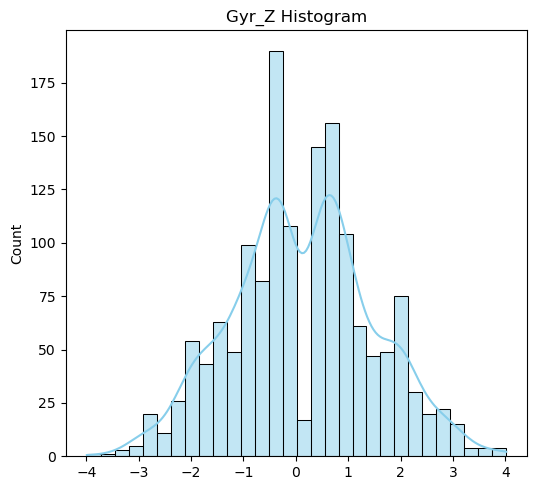

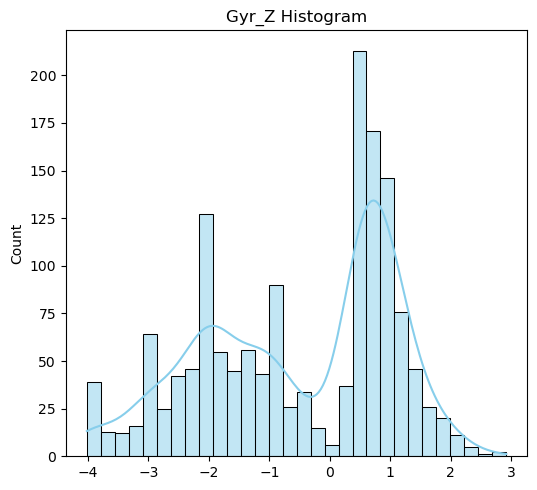

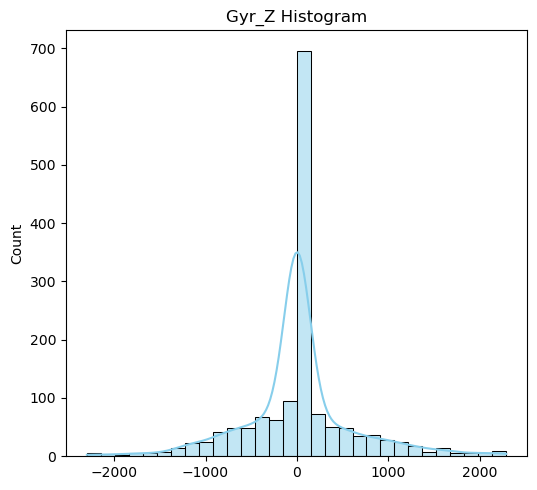

In [62]:
plot_histogram(mmx)
plot_histogram(mmy)
plot_histogram(mmz)

In [9]:
# x y 좌표 추출
result = []
for item in labels:
    # 문자열에서 숫자를 추출
    numbers = re.findall(r'-?\d+', item[0])
    # 정수로 변환 후 앞의 두 숫자만 가져와 리스트에 추가
    result.append(list(map(int, numbers[:2])))
result = np.array(result)

In [10]:
import tensorflow as tf

def residual_block(x, filters):
    shortcut = x  # 원본 입력을 저장 (skip connection)
    
    x = Conv1D(filters, 3, padding="same")(x)
    x = ReLU()(x)
    x = Conv1D(filters, 3, padding="same")(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding="same")(shortcut)
    # Skip connection: 입력을 출력과 더함
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# ✅ ResNet + LSTM 모델 구축
def build_resnet_lstm_model(input_shape=(10, 3)):  # (시퀀스 길이, 특징 개수)
    inputs = Input(shape=input_shape)
    
    # CNN 기반 특징 추출
    x = Conv1D(8, 3, padding="same")(inputs)
    x = ReLU()(x)
    
    # Residual Blocks 추가
    x = residual_block(x, 16)
    x = MaxPooling1D()(x)
    
    x = residual_block(x, 32)
    x = MaxPooling1D()(x)
    
    x = residual_block(x, 64)
    x = GlobalMaxPooling1D()(x)
    
    # LSTM 적용
    x = tf.expand_dims(x, axis=1)  # LSTM을 위한 차원 확장 (Batch, 1, Features)
    x = LSTM(128, return_sequences=False)(x)
    
    # Fully Connected Layer
    x = Dense(64)(x)
    outputs = Dense(2)(x)  # (x, y) 좌표 출력
    
    model = Model(inputs, outputs)
    return model

# 모델 생성 및 컴파일
model = build_resnet_lstm_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 8)        80          ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 10, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 10, 16)       400         ['re_lu[0][0]']                  
                                                                                              

In [385]:
def build_resnet_model(input_shape=(5, 3)):
    inputs = Input(shape=input_shape)
    x = Conv1D(8, 3, padding="same")(inputs)
    x = ReLU()(x)
    x = Conv1D(16, 3, padding="same")(x)
    x = ReLU()(x)
    x = MaxPooling1D()(x)
    x = Conv1D(32, 3, padding="same")(x)
    x = ReLU()(x)
    x = MaxPooling1D()(x)
    x = Conv1D(64, 3, padding="same")(x)
    x = ReLU()(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128)(x)
    #x = RELU()(x)
    outputs = Dense(2)(x)  # (x, y) 좌표 출력
    
    model = Model(inputs, outputs)
    return model

# 모델 생성 및 컴파일
model = build_resnet_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 5, 3)]            0         
                                                                 
 conv1d_162 (Conv1D)         (None, 5, 8)              80        
                                                                 
 re_lu_123 (ReLU)            (None, 5, 8)              0         
                                                                 
 conv1d_163 (Conv1D)         (None, 5, 16)             400       
                                                                 
 re_lu_124 (ReLU)            (None, 5, 16)             0         
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 2, 16)            0         
 g1D)                                                            
                                                          

In [11]:
original_result = result
scaler = MinMaxScaler()
scaler.fit(result)
standard_result = scaler.transform(result)

# Train Model

In [405]:
# train test set 분리
X_train, X_test, y_train, y_test = train_test_split(data, standard_result, test_size=0.2, random_state=777, shuffle=False)

# model 훈련
#es = EarlyStopping(patience=20)
#rlr = ReduceLROnPlateau(factor=0.1, patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=1)

# model 저장
path = "path" + str("106")
model.save(path, ".h5")

# model 평가
model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# 모델 학습 진행 후...
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Epoch 1/100
603/603 [==============================] - 17s 24ms/step - loss: 0.0434 - mae: 0.1691
Epoch 2/100
603/603 [==============================] - 15s 24ms/step - loss: 0.0294 - mae: 0.1349
Epoch 3/100
603/603 [==============================] - 14s 24ms/step - loss: 0.0281 - mae: 0.1309
Epoch 4/100
603/603 [==============================] - 15s 24ms/step - loss: 0.0274 - mae: 0.1292
Epoch 5/100
603/603 [==============================] - 15s 24ms/step - loss: 0.0269 - mae: 0.1279
Epoch 6/100
603/603 [==============================] - 15s 25ms/step - loss: 0.0261 - mae: 0.1252
Epoch 7/100
603/603 [==============================] - 14s 24ms/step - loss: 0.0257 - mae: 0.1262
Epoch 8/100
603/603 [==============================] - 15s 24ms/step - loss: 0.0260 - mae: 0.1264
Epoch 9/100
603/603 [==============================] - 14s 23ms/step - loss: 0.0258 - mae: 0.1256
Epoch 10/100
603/603 [==============================] - 14s 23ms/step - loss: 0.0256 - mae: 0.1248
Epoch 11/100
603/60

INFO:tensorflow:Assets written to: path106\assets


INFO:tensorflow:Assets written to: path106\assets


5/5 [==============================] - 1s 3ms/step


# LOOCV Model

In [ ]:
loocv_model(data, standard_result)

1/1 [==============================] - 1s 702ms/step
Fold 1 Test Results:
y_test: [ 10. 161.]
y_pred: [ 49.32257 224.70244]
Difference: [-39.3225708  -63.70243835]
1/1 [==============================] - 1s 692ms/step
Fold 2 Test Results:
y_test: [ 52. 189.]
y_pred: [ 77.40155 226.80753]
Difference: [-25.40155029 -37.80752563]
1/1 [==============================] - 1s 1s/step
Fold 3 Test Results:
y_test: [ 99. 290.]
y_pred: [110.392555 272.36465 ]
Difference: [-11.39255524  17.63534546]
1/1 [==============================] - 1s 625ms/step
Fold 4 Test Results:
y_test: [-63. 232.]
y_pred: [-47.270916 219.08057 ]
Difference: [-15.72908401  12.91943359]
1/1 [==============================] - 1s 712ms/step
Fold 5 Test Results:
y_test: [ 83. 282.]
y_pred: [134.96552 240.83899]
Difference: [-51.96551514  41.16101074]
1/1 [==============================] - 1s 550ms/step
Fold 6 Test Results:
y_test: [  2. 314.]
y_pred: [ -2.0344222 237.28554  ]
Difference: [ 4.03442216 76.71446228]
1/1 [========

In [406]:
# predictions을 정규화 전 상태로
original_labels = scaler.inverse_transform(predictions)
original_labels

array([[ -17.57476   ,  330.0709    ],
       [  42.17784   ,  233.9589    ],
       [  89.15209   ,  231.87138   ],
       [ -44.122185  ,  263.83554   ],
       [  -6.796834  ,  417.7947    ],
       [ -51.241978  ,  263.1197    ],
       [ -87.47588   ,  395.1026    ],
       [ 107.65481   ,  313.5536    ],
       [ -40.644012  ,  330.8838    ],
       [  58.333286  ,  208.64908   ],
       [ -29.038717  ,  289.01663   ],
       [   3.0885434 ,  298.3957    ],
       [ -69.06736   ,  205.68391   ],
       [-104.74955   ,  276.17468   ],
       [ 144.6278    ,  348.6861    ],
       [   4.1566124 ,  342.5004    ],
       [  76.287056  ,  218.93184   ],
       [  58.899296  ,  198.23232   ],
       [ 118.69098   ,  345.8552    ],
       [  84.91745   ,  284.6695    ],
       [ -86.573265  ,  218.1446    ],
       [ -69.11993   ,  337.43384   ],
       [ -70.15543   ,  322.80258   ],
       [-104.46205   ,  334.3072    ],
       [ 104.8015    ,  410.92215   ],
       [  57.83774   ,  2

In [407]:
# train test set 분리
X_train, X_test, y_train, y_test = train_test_split(data, original_result, test_size=0.2, random_state=777, shuffle=False)
y_test

array([[ -22,  497],
       [   8,  275],
       [ 195,  346],
       [ -19,  253],
       [  -2,  340],
       [ -61,  233],
       [ -51,  111],
       [ 117,  402],
       [ -31,  311],
       [  25,  209],
       [  -8,  208],
       [  -3,  217],
       [  -6,  230],
       [ -72,  285],
       [  25,  272],
       [  15,  255],
       [  49,  256],
       [  42,  385],
       [  80,  295],
       [  94,  175],
       [ -93,  312],
       [-151,  379],
       [ -14,  222],
       [ -27,  146],
       [ 117,  304],
       [  53,  296],
       [ 112,  173],
       [ -22,  320],
       [-118,  219],
       [ -93,  371],
       [ -19,  325],
       [  42,  391],
       [  18,  236],
       [  16,  284],
       [  15,  272],
       [ -44,  247],
       [  12,  150],
       [ -13,  255],
       [ 110,  491],
       [   4,  333],
       [  75,  259],
       [-154,  414],
       [-101,  246],
       [  -2,  324],
       [  23,  161],
       [ 131,  217],
       [   7,  284],
       [ -37,

In [408]:
dd = y_test-original_labels
np.set_printoptions(suppress=True)

In [409]:
# 절댓값이 100 이상인 값들의 인덱스 찾기
indices = np.where(np.abs(dd[:,0]) >= 100)[0]

if len(indices) > 0:
    max_index = indices[-1]  # 가장 마지막으로 조건을 만족하는 인덱스
    print("절댓값이 100 이상인 값들:", dd[indices])
    print("해당 인덱스까지의 배열:", indices)
else:
    print("절댓값이 100 이상인 값이 없습니다.")

절댓값이 100 이상인 값들: [[ 105.84790802  114.12861633]
 [-119.62780762  -76.68609619]
 [-102.39920807 -136.15216064]
 [-104.18952179   13.22271729]
 [ 110.3514328    35.49691772]
 [ 102.64112091  106.37953186]
 [ 123.45200443  -54.97357178]
 [-143.60561371 -105.11495972]
 [ 188.21379089 -127.68942261]
 [-122.32408142 -131.07513428]]
해당 인덱스까지의 배열: [  2  14  63  66  93  94 104 109 117 134]


KeyError: 'val_loss'

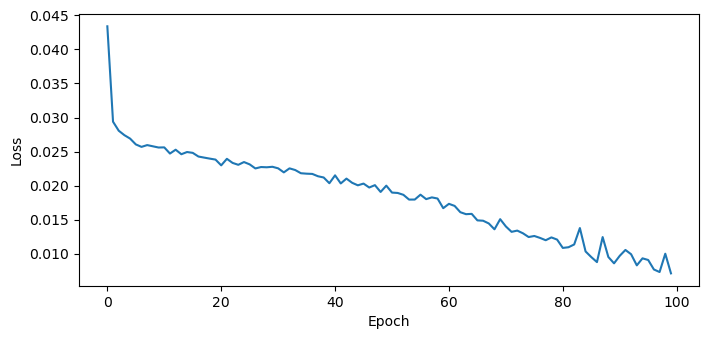

In [410]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.legend()

  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

In [411]:
from scipy.stats import skew, kurtosis

def calculate_and_visualize_diff(y_test, original_labels):
    # 데이터프레임 생성
    df = pd.DataFrame()
    df['X_coordinate'] = np.abs(y_test[:, 0] - original_labels[:, 0])
    df['Y_coordinate'] = np.abs(y_test[:, 1] - original_labels[:, 1])
    
    # 통계 값 계산
    stats = {}
    for col in ['X_coordinate', 'Y_coordinate']:
        stats[col] = {
            "mean": df[col].mean(),
            "median": df[col].median(),
            "std": df[col].std(),
            "iqr": np.percentile(df[col], 75) - np.percentile(df[col], 25),
            "min": df[col].min(),
            "max": df[col].max(),
            "skewness": skew(df[col]),
            "kurtosis": kurtosis(df[col])
        }
    
    # 통계 정보 출력
    for col, values in stats.items():
        print(f"Statistics for {col}:")
        for key, value in values.items():
            print(f"  {key.capitalize()}: {value:.2f}")
    
    # 분포도 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.histplot(df['X_coordinate'], bins=30, kde=True, color='blue', alpha=0.6, ax=axes[0])
    axes[0].axvline(stats['X_coordinate']['mean'], color='red', linestyle='dashed', linewidth=2, label=f'Mean: {stats["X_coordinate"]["mean"]:.2f}')
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Distribution of Absolute Differences (X Coordinate)")
    axes[0].legend()
    
    sns.histplot(df['Y_coordinate'], bins=30, kde=True, color='orange', alpha=0.6, ax=axes[1])
    axes[1].axvline(stats['Y_coordinate']['mean'], color='red', linestyle='dashed', linewidth=2, label=f'Mean: {stats["Y_coordinate"]["mean"]:.2f}')
    axes[1].set_xlabel("Y Coordinate")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Distribution of Absolute Differences (Y Coordinate)")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return stats

Statistics for X_coordinate:
  Mean: 39.76
  Median: 33.02
  Std: 32.88
  Iqr: 40.56
  Min: 0.25
  Max: 188.21
  Skewness: 1.36
  Kurtosis: 2.42
Statistics for Y_coordinate:
  Mean: 105.98
  Median: 96.82
  Std: 74.46
  Iqr: 110.84
  Min: 0.35
  Max: 335.12
  Skewness: 0.68
  Kurtosis: -0.09


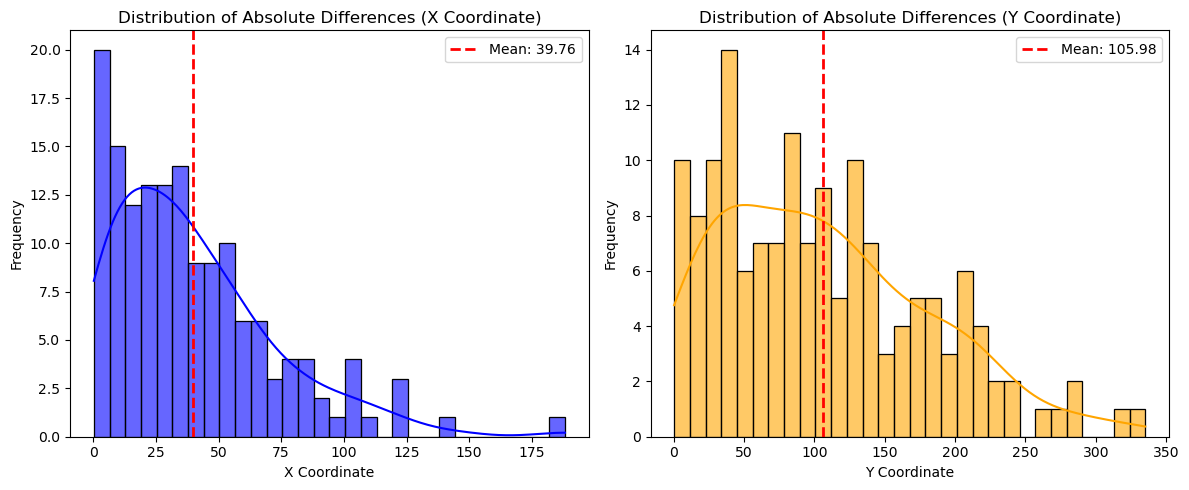

{'X_coordinate': {'mean': 39.756029215869525,
  'median': 33.01606011390686,
  'std': 32.87959911487182,
  'iqr': 40.56265074014664,
  'min': 0.247802734375,
  'max': 188.2137908935547,
  'skewness': 1.355484067324263,
  'kurtosis': 2.4185267390062295},
 'Y_coordinate': {'mean': 105.983583665052,
  'median': 96.82005310058594,
  'std': 74.46088327732281,
  'iqr': 110.84282684326172,
  'min': 0.350921630859375,
  'max': 335.1199951171875,
  'skewness': 0.6845535135486703,
  'kurtosis': -0.09208578473785911}}

In [412]:
calculate_and_visualize_diff(y_test, original_labels)

In [413]:
# 첫 번째 값의 부호가 다른 경우 필터링
mask = (original_labels[:, 0] * y_test[:, 0]) < 0
filtered_y_pred = original_labels[mask]
filtered_y_test = y_test[mask]

In [414]:
df = pd.DataFrame({
    "y_pred_0": filtered_y_pred[:, 0],
    "y_test_0": filtered_y_test[:, 0],
    "y_pred_1": filtered_y_pred[:, 1],
    "y_test_1": filtered_y_test[:, 1]
})
df

,y_pred_0,y_test_0,y_pred_1,y_test_1
0,3.088543,-3,298.395691,217
1,49.896595,-2,364.786041,324
2,52.410156,-8,265.167572,323
3,-2.206612,11,200.196274,324
4,-2.586791,35,413.119995,78
5,-11.452004,112,398.973572,344
6,3.925087,-50,298.301788,405
7,-54.213791,134,447.689423,320
8,12.110993,-13,350.158295,277
9,1.564086,-27,317.452972,187


In [ ]:
# 파일 전부 읽어오기

path = "D:\ㅎㅅㅂ\Puck_data"

file_list = glob.glob(path+'/**')
files = []
labels = []
for i in range(len(file_list)):
    f = glob.glob(file_list[i]+'/**')
    for x in f:
        if x.endswith('.csv'):
            files.append(x)
            matches = re.findall(r'\([^\(\)]*\)', x)
            labels.append(matches)

In [ ]:
# 데이터 전처리

data = []
#mmx = []
#mmy = []
#mmz = []

for i in files:
    file = extract_data(i)
    #print(file["Acc_X"].max(), file["Acc_X"].min())
    #mmx.append(file["Acc_X"].max())
    #mmx.append(file["Acc_X"].min())
    #mmy.append(file["Acc_Y"].max())
    #mmy.append(file["Acc_Y"].min())
    #mmz.append(file[" Gyr_Z"].max())
    #mmz.append(file[" Gyr_Z"].min())
    insert_data = cut_length(file)
    data.append(insert_data)
data = np.array(data)

In [ ]:
# x y 좌표 추출
result = []
for item in labels:
    # 문자열에서 숫자를 추출
    numbers = re.findall(r'-?\d+', item[0])
    # 정수로 변환 후 앞의 두 숫자만 가져와 리스트에 추가
    result.append(list(map(int, numbers[-1])))
result = np.array(result)